<a href="https://colab.research.google.com/github/AyushYadav76/Fake_Social_Media_Account_Detection/blob/main/SocialAnayst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from datetime import datetime
import joblib


In [17]:
# Load dataset
df= pd.read_csv("/content/fake_twitter_accounts_final (1).csv")
print(df.head())

df = df.drop("url", axis=1)
df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', utc=True)
reference_date = pd.Timestamp('2015-02-14', tz='UTC')
df['account_age'] = (reference_date - df['created_at']).dt.days

          id                name   screen_name  statuses_count  \
0  370098498        pirfectmoses  pirfectmoses              24   
1   37384589            SAK Nair   bsknair1967             656   
2   72110028              Deepak       dedjven            1234   
3   82885728     Marcos Vinicius     BrowAlves             573   
4  110120789  Shri Kant Kanaujia    kanaujiask             675   

   followers_count  friends_count  favourites_count  listed_count  \
0                4            588                16             0   
1               57            693               597             0   
2               15            104              1150             0   
3               14            227               530             0   
4               18            519               653             0   

                       created_at  url  ...  \
0  Thu Sep 08 13:20:35 +0000 2011  NaN  ...   
1  Sun May 03 07:35:13 +0000 2009  NaN  ...   
2  Sun Sep 06 19:50:08 +0000 2009  NaN  ...   


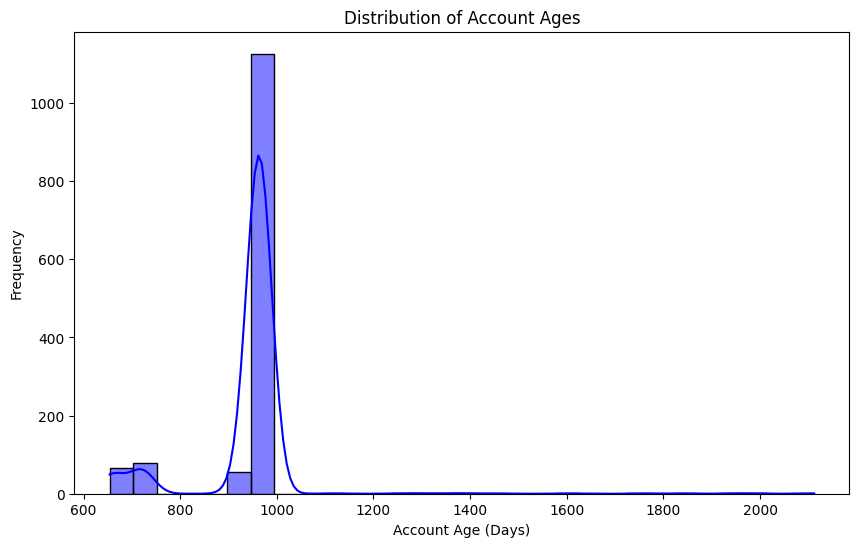

In [18]:
# Plot account age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['account_age'], bins=30, kde=True, color='blue')
plt.title('Distribution of Account Ages')
plt.xlabel('Account Age (Days)')
plt.ylabel('Frequency')
plt.show()

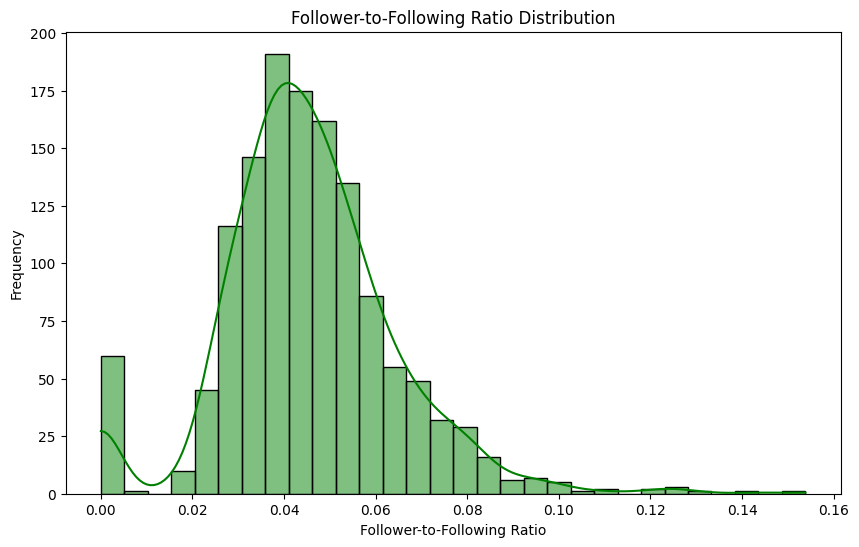

Data Types:
id                                                  int64
name                                               object
screen_name                                        object
statuses_count                                      int64
followers_count                                     int64
friends_count                                       int64
favourites_count                                    int64
listed_count                                        int64
created_at                            datetime64[ns, UTC]
lang                                               object
time_zone                                          object
location                                           object
default_profile                                   float64
default_profile_image                             float64
geo_enabled                                       float64
profile_image_url                                  object
profile_banner_url                                 object
pr

In [19]:
# Compute follower-to-following ratio
df['follower_to_following_ratio'] = df['followers_count'] / (df['friends_count'] + 1)

# Plot follower-to-following ratio distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['follower_to_following_ratio'], bins=30, kde=True, color='green')
plt.title('Follower-to-Following Ratio Distribution')
plt.xlabel('Follower-to-Following Ratio')
plt.ylabel('Frequency')
plt.show()

print("Data Types:")
print(df.dtypes)

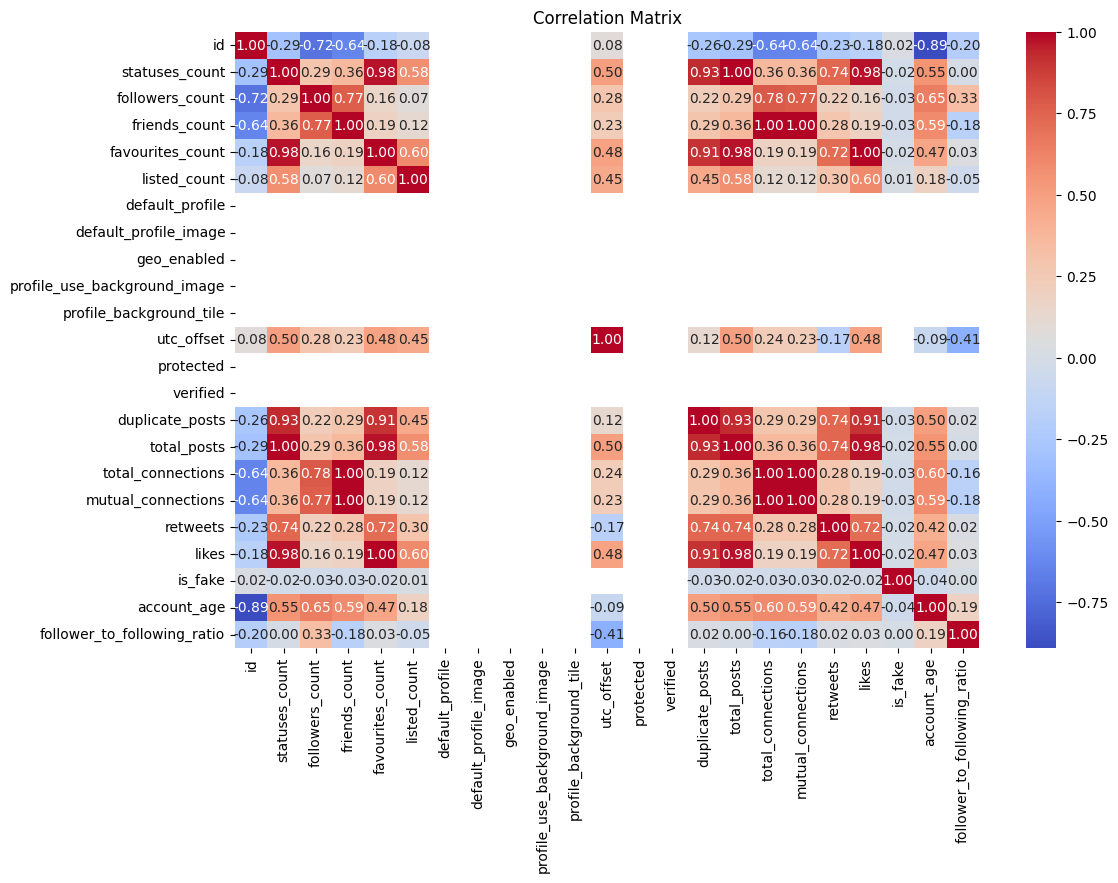

In [20]:
# Correlation matrix
numeric_data = df.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [22]:
# Feature engineering
df['bio_length'] = df['description'].apply(lambda x: len(str(x)))
df['profile_picture_present'] = df['description'].apply(lambda x: 1 if x != 'default.jpg' else 0)
df['default_profile_picture'] = df['description'].apply(lambda x: 1 if x == 'default.jpg' else 0)
df['average_posts_per_day'] = df['statuses_count'] / (df['account_age'] + 1)
df['hour_of_day'] = df['created_at'].dt.hour
df['peak_activity_hour'] = df.groupby('id')['hour_of_day'].transform(lambda x: x.mode()[0])
df['account_creation_date'] = pd.to_datetime(df['created_at'], errors='coerce')
df['account_creation_year'] = df['account_creation_date'].dt.year
df['retweet_to_like_ratio'] = df['retweets'] / (df['likes'] + 1)
df['engagement_rate'] = (df['likes'] + df['retweets']) / (df['total_posts'] + 1)

In [23]:
df['clustering_coefficient'] = df['mutual_connections'] / (df['total_connections'] + 1)
df['mutual_connection_ratio'] = df['mutual_connections'] / (df['total_connections'] + 1)
df['spam_score'] = df['duplicate_posts'] / (df['total_posts'] + 1)

In [24]:
# Define features and target variable
features = [
    'account_age', 'bio_length', 'profile_picture_present', 'default_profile_image',
    'average_posts_per_day', 'retweet_to_like_ratio', 'engagement_rate',
    'account_creation_year', 'peak_activity_hour', 'clustering_coefficient',
    'mutual_connection_ratio', 'spam_score'
]
X = df[features]
y = df['is_fake']

In [25]:
df['description'] = pd.to_numeric(df['description'], errors='coerce')
df['description'].fillna(df['description'].mean(), inplace=True)

<ipython-input-25-1e626e58a24d>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['description'].fillna(df['description'].mean(), inplace=True)


In [26]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Ensure alignment of X_train_scaled and y_train
min_length = min(X_train_scaled.shape[0], y_train.shape[0])
X_train_scaled = X_train_scaled[:min_length]
y_train = y_train[:min_length]

In [28]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

In [29]:
# Train Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Evaluate on test set
y_pred_log_reg = log_reg.predict(X_test_scaled)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("ROC-AUC Score:", roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1]))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.53      0.57       165
           1       0.37      0.45      0.41       103

    accuracy                           0.50       268
   macro avg       0.49      0.49      0.49       268
weighted avg       0.52      0.50      0.51       268

ROC-AUC Score: 0.5092085907619889


In [30]:
# Train Random Forest model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train)

# Evaluate on test set
y_pred_rf = rf.predict(X_test_scaled)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1]))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.84      0.71       165
           1       0.37      0.15      0.21       103

    accuracy                           0.57       268
   macro avg       0.49      0.49      0.46       268
weighted avg       0.52      0.57      0.52       268

ROC-AUC Score: 0.5031185642836129


In [31]:
# Train XGBoost model
xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)
xgb.fit(X_train_scaled, y_train)

# Evaluate on test set
y_pred_xgb = xgb.predict(X_test_scaled)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, xgb.predict_proba(X_test_scaled)[:, 1]))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       165
           1       0.43      0.31      0.36       103

    accuracy                           0.57       268
   macro avg       0.53      0.53      0.52       268
weighted avg       0.55      0.57      0.56       268

ROC-AUC Score: 0.5618711385701677


In [32]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Evaluate best model
y_pred_best_rf = best_rf.predict(X_test_scaled)
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, best_rf.predict_proba(X_test_scaled)[:, 1]))


Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.75      0.68       165
           1       0.38      0.24      0.30       103

    accuracy                           0.56       268
   macro avg       0.50      0.50      0.49       268
weighted avg       0.52      0.56      0.53       268

ROC-AUC Score: 0.5372168284789645


In [33]:
# Save the best model
joblib.dump(best_rf, 'fake_account_detection_model.pkl')


['fake_account_detection_model.pkl']